In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import re
from matplotlib import pyplot as plt
import scipy.io as sio
import numpy as np
import pickle as pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from scipy import signal
import scipy.io
import os
import math

import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
# from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, Conv2D, MaxPooling2D, RepeatVector
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset_path = '/content/drive/My Drive/Major/BED_dataset_RAW_PARSED/'

In [ ]:
def load_eeg_data(directory):
    data = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.mat'):
            filepath = os.path.join(directory, filename)

            mat_contents = scipy.io.loadmat(filepath)
            recordings = mat_contents['recording']

            recordings = recordings[:30208, 2:-1]
            recordings = recordings.T

            data.append(recordings)

            # Extract label from filename
            start_index = filename.index('s') + 1
            end_index = filename.index('_')
            # Extract the substring between 's' and '_'
            number = filename[start_index:end_index]
            person_id = int(number) # Convert the extracted number to an integer

            label = person_id - 1
            labels.append(label)

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [ ]:
eeg_data, labels = load_eeg_data(dataset_path)

print("EEG data shape:", eeg_data.shape)
print("Labels shape:", labels.shape)

EEG data shape: (63, 14, 30208)
Labels shape: (63,)


In [ ]:
eeg_Label = []
for i in labels:
    for j in range (0,14):
        eeg_Label.append(i)

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(eeg_Label)

y.shape

(882, 21)

In [ ]:
import functools
def combine_dims(a, i=0, n=1):
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])

In [ ]:
eeg_Data = combine_dims(np.array(eeg_data), 0)

eeg_Data.shape

(882, 30208)

In [ ]:
fs = 256

size_dataset = len(eeg_Data)
nperseg = 512
noverlap = 256
f_size = math.ceil(((nperseg + 1)/2))
t_size = int((eeg_Data[0].size - noverlap ) / (nperseg - noverlap))
X_full = np.ndarray(shape=(size_dataset, f_size, t_size, 3))

for i in range(0, size_dataset):
  for j in range(0,3):
    X = eeg_Data[i]
    f, t, Sxx = spectrogram(X, fs, nperseg = nperseg, noverlap = noverlap, mode='psd')
    X_full[i, :, :, j] = Sxx

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

X_train /= 255
X_test /= 255

In [ ]:
num_classes = 21

input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights based on imbalance ratio
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)

# Convert class_weights array to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3),
          strides=(1, 1),
          activation='relu',
          input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3),
          activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(RepeatVector(4))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))


model.add(Dense(num_classes, activation="softmax"))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 255, 47, 32)       896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 21, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 10, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 62, 10, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 39680)            

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer ="Adam", loss =keras.losses.categorical_crossentropy, metrics=['accuracy'])
m=model.fit(X_train, y_train,epochs=100,batch_size=256,verbose=1,validation_data=(X_test, y_test), class_weight=class_weights_dict, callbacks =[es, mc])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 2.9852 - accuracy: 0.1220 
Epoch 1: val_accuracy improved from -inf to 0.25424, saving model to best_model.h5
3/3 [==============================] - 50s 16s/step - loss: 2.9852 - accuracy: 0.1220 - val_loss: 2.8119 - val_accuracy: 0.2542
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 2.7293 - accuracy: 0.2695 
Epoch 2: val_accuracy improved from 0.25424 to 0.27684, saving model to best_model.h5
3/3 [==============================] - 40s 14s/step - loss: 2.7293 - accuracy: 0.2695 - val_loss: 2.5944 - val_accuracy: 0.2768
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2.5023 - accuracy: 0.3532 
Epoch 3: val_accuracy improved from 0.27684 to 0.37853, saving model to best_model.h5
3/3 [==============================] - 39s 13s/step - loss: 2.5023 - accuracy: 0.3532 - val_loss: 2.3461 - val_accuracy: 0.3785
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 2.2655 - acc

In [ ]:
saved_model = load_model('best_model.h5')

In [ ]:
_, train_f1 = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_f1 = saved_model.evaluate(X_test, y_test, verbose=0)

print(test_f1)

0.8926553726196289


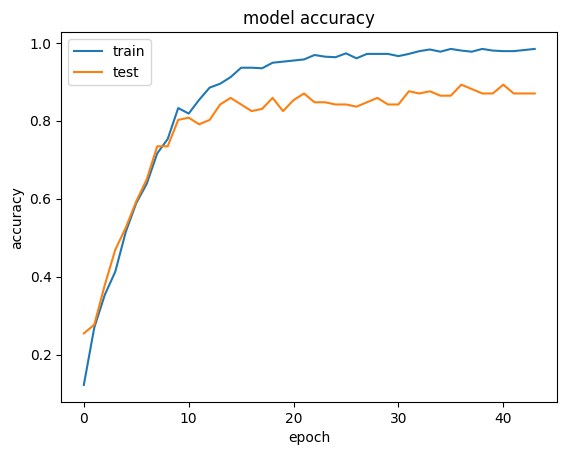

In [ ]:
import matplotlib.pyplot as plt
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
y_test1=np.argmax(y_test, axis=1)

y_pred_saved = saved_model.predict(X_test)
y_pred_saved=np.argmax(y_pred_saved,axis=1)

6/6 [==============================] - 3s 373ms/step


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test1,y_pred_saved))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.75      0.86      0.80         7
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00        11
           4       0.80      1.00      0.89         8
           5       0.92      1.00      0.96        11
           6       0.86      0.75      0.80         8
           7       1.00      1.00      1.00        12
           8       0.88      0.88      0.88         8
           9       0.86      0.86      0.86         7
          10       1.00      0.86      0.92         7
          11       0.86      0.86      0.86         7
          12       1.00      1.00      1.00        13
          13       1.00      0.73      0.84        11
          14       0.83      0.83      0.83         6
          15       1.00      0.89      0.94         9
          16       0.78      0.88      0.82         8
          17       1.00    

In [ ]:
saved_model = load_model('best_model.h5')
saved_model.save('/content/drive/My Drive/saved_models/BED_14.h5')